# KE5105 - Building Electrical Consumption Forecasting

# Modelling 9 - Fine-tune model

## Summary of Findings
* 4x128 GRU, 2x32 Dense Model
	* L1 (1e-5), L2 (1e-5) Weight Regularisation
		* Minimum Validation MAE = 2.279
		* Still converging very slowly
	* L1 (1e-6), L2 (1e-6) Weight Regularisation
		* Minimum Validation MAE = 1.970
	* L1 (1e-7), L2 (1e-7) Weight Regularisation
		* Minimum Validation MAE = 1.777 (0.0167) @ epoch 155

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.regularizers import l1,l2, l1_l2

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5 = mu.load_data_by_bldg(['AS5'], 'processed')

In [5]:
as5[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

## Split the data into train and test set

In [6]:
as5_train_df = as5[0][1].loc['2015-06-12 08:00:00':'2017-03-31 23:30:00', :]

In [7]:
as5_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     29985 non-null float64
B

In [8]:
as5_test_df = as5[0][1].loc['2018-01-01 00:00:00':, :]

In [9]:
as5_test_df.index.max()

Timestamp('2018-12-31 23:30:00')

In [10]:
as5_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2018-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         16145 non-null float64
PWMEXTAS4ExBldg                   16145 non-null float64
PWMAS4LanguageCenter              16145 non-null float64
PWMCANTEEN                        16145 non-null float64
PWMStreetLight                    16145 non-null float64
BTUAS5                            16144 non-null float64
PWMMainIC_30min_avg               16132 non-null float64
PWMEXTAS4ExBldg_30min_avg         16132 non-null float64
PWMAS4LanguageCenter_30min_avg    16132 non-null float64
PWMCANTEEN_30min_avg              16132 non-null float64
PWMStreetLight_30min_avg          16132 non-null float64
BTUAS5_30min_avg                  16130 non-null float64
PWM_sumadd                        16132 non-null float64
PWM_sumsubtract                   16132 non-null float64
PWM_30min_avg                     16132 non-null float64
B

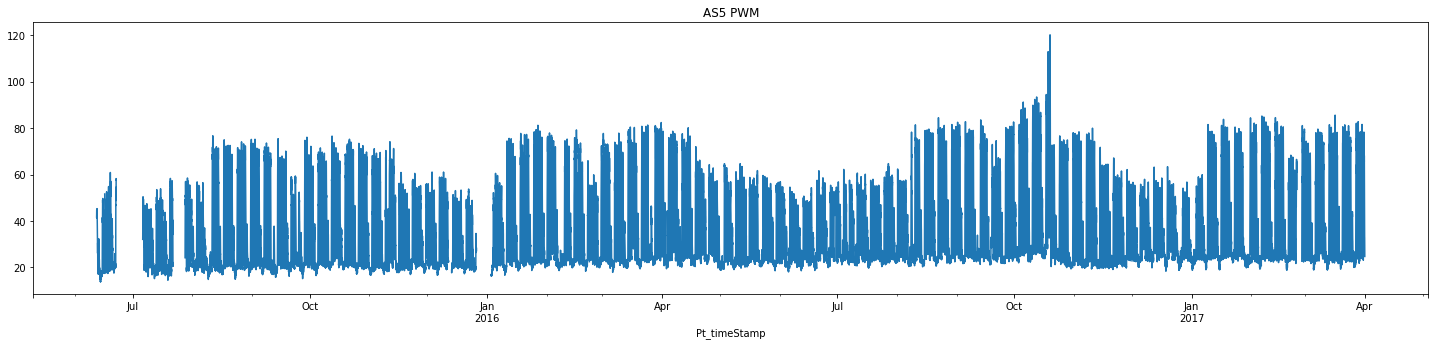

In [11]:
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [12]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## Normalise the training data

* Convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [13]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [14]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[ 0.26254935,  0.56924225],
       [ 0.26724948,  0.53427896],
       [ 0.28031585,  0.53353241],
       ...,
       [ 0.12897161,  0.03222595],
       [ 0.10312089,  0.00348389],
       [-1.        , -1.        ]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

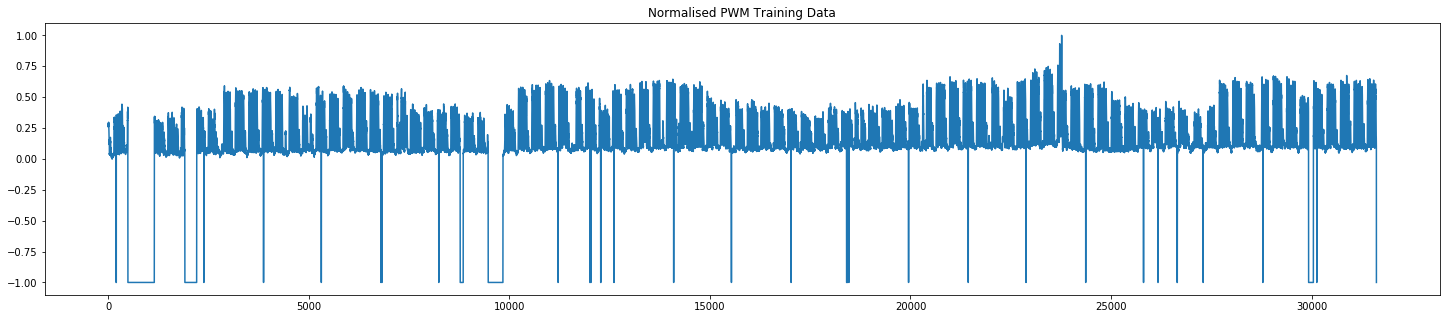

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

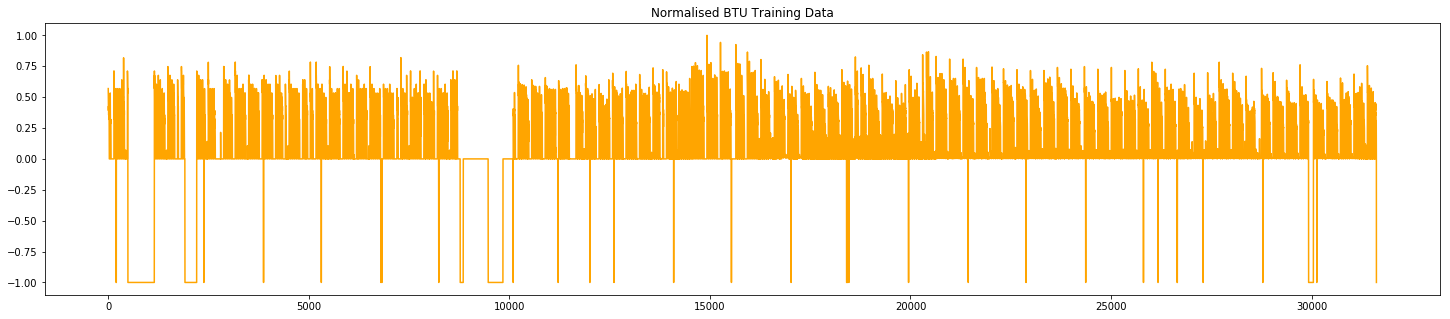

In [16]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [17]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [18]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## 4x128 GRU, 2x32 Dense Model with L1 (1e-5), L2 (1e-5) Weight Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-5, 1e-5), recurrent_regularizer=l1_l2(1e-5, 1e-5), bias_regularizer=l1_l2(1e-5, 1e-5),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-5, 1e-5), recurrent_regularizer=l1_l2(1e-5, 1e-5), bias_regularizer=l1_l2(1e-5, 1e-5),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-5, 1e-5), recurrent_regularizer=l1_l2(1e-5, 1e-5), bias_regularizer=l1_l2(1e-5, 1e-5),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-5, 1e-5), recurrent_regularizer=l1_l2(1e-5, 1e-5), bias_regularizer=l1_l2(1e-5, 1e-5)))

# model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
# model.add(layers.CuDNNGRU(128, return_sequences=True))
# model.add(layers.CuDNNGRU(128, return_sequences=True))
# model.add(layers.CuDNNGRU(128))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [34]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0100.h5'))
model.summary()

In [57]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-01-23 14:40:37.989801


Epoch 1/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.0252 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.5167


Epoch 2/50


 - 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.0743 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 9.4710


Epoch 3/50


 - 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.0001 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.5158


Epoch 4/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 12.0460 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 10.1932


Epoch 5/50


 - 12s - loss: 0.0216 - mean_absolute_percentage_error: 12.2132 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 9.8238


Epoch 6/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.1207 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 10.5365


Epoch 7/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.0677 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.4501


Epoch 8/50


Epoch 7/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.0621 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 9.5437


Epoch 9/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8695 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.9504


Epoch 10/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 11.9371 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 9.6985


Epoch 11/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.7887 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.4379


Epoch 12/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 11.9218 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.8202


Epoch 13/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.8597 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.1694


Epoch 14/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.0130 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 10.3291


Epoch 15/50


 - 12s - loss: 0.0215 - mean_absolute_percentage_error: 12.0434 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 10.0208


Epoch 16/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9473 - val_loss: 0.0259 - val_mean_absolute_percentage_error: 12.4051


Epoch 17/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.9605 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.6545


Epoch 18/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 12.1111 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.3589


Epoch 19/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.9175 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.4277


Epoch 20/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.9120 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.7694


Epoch 21/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 12.0397 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 10.4734


Epoch 22/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9377 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 10.4196


Epoch 23/50


Epoch 22/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 12.0793 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2781


Epoch 24/50


 - 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.9607 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 10.4472


Epoch 25/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9473 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.2988


Epoch 26/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9765 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.8800


Epoch 27/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.9786 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 9.6062


Epoch 28/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9382 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2624


Epoch 29/50


 - 12s - loss: 0.0214 - mean_absolute_percentage_error: 11.9689 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 9.2856


Epoch 30/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8586 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2597


Epoch 31/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8586 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2597


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8541 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 9.3854


Epoch 32/50


 - 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.7822 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.3939


Epoch 33/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.8975 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.7773


Epoch 34/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.9424 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 11.9450


Epoch 35/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8599 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 9.3878


Epoch 36/50


 - 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.9035 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 9.8548


Epoch 36/50


Epoch 37/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.8911 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 9.7341


Epoch 38/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9494 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 9.3093


Epoch 39/50


Epoch 38/50


 - 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.8650 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.2387


Epoch 40/50


 - 12s - loss: 0.0213 - mean_absolute_percentage_error: 11.9923 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 9.2746


Epoch 41/50


 - 12s - loss: 0.0212 - mean_absolute_percentage_error: 11.8978 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2347


Epoch 42/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.9196 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 9.3779


Epoch 43/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.8645 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.3614


Epoch 44/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 12.0099 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.1730


Epoch 45/50


 - 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.8214 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 9.2901


Epoch 46/50


 - 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.8249 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.6672


Epoch 47/50


 - 13s - loss: 0.0213 - mean_absolute_percentage_error: 11.8620 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 9.2865


Epoch 48/50


 - 13s - loss: 0.0211 - mean_absolute_percentage_error: 11.7696 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 9.5531


Epoch 49/50


 - 13s - loss: 0.0211 - mean_absolute_percentage_error: 11.6956 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 9.6526


Epoch 50/50


 - 13s - loss: 0.0212 - mean_absolute_percentage_error: 11.8894 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 9.1538



Training Duration = 0:10:19.413158


In [58]:
# histories = [] # for first training session
histories.append(history.history)

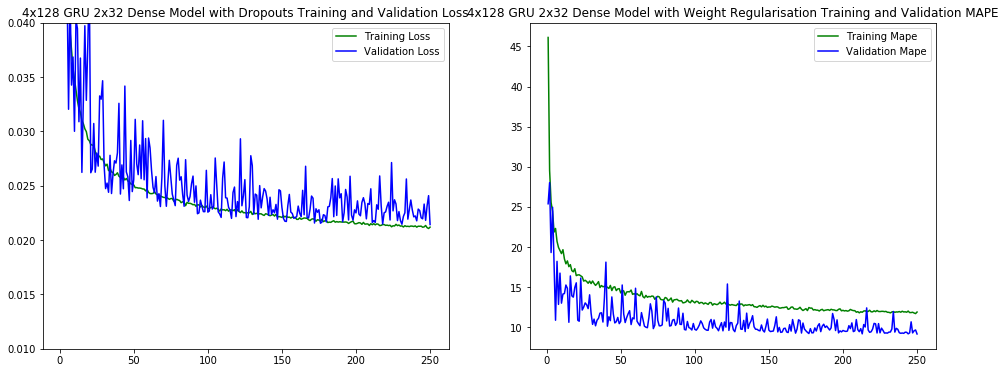

In [60]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim((0.01, 0.04))
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight Regularisation Training and Validation MAPE')
plt.legend()
plt.show()

In [61]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.240972
Validation MAE = 2.279410


In [62]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [63]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

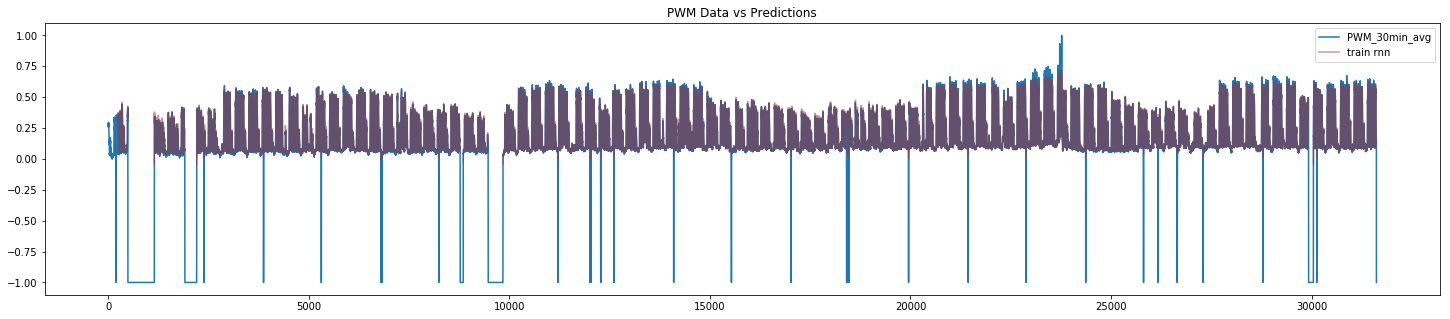

In [64]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

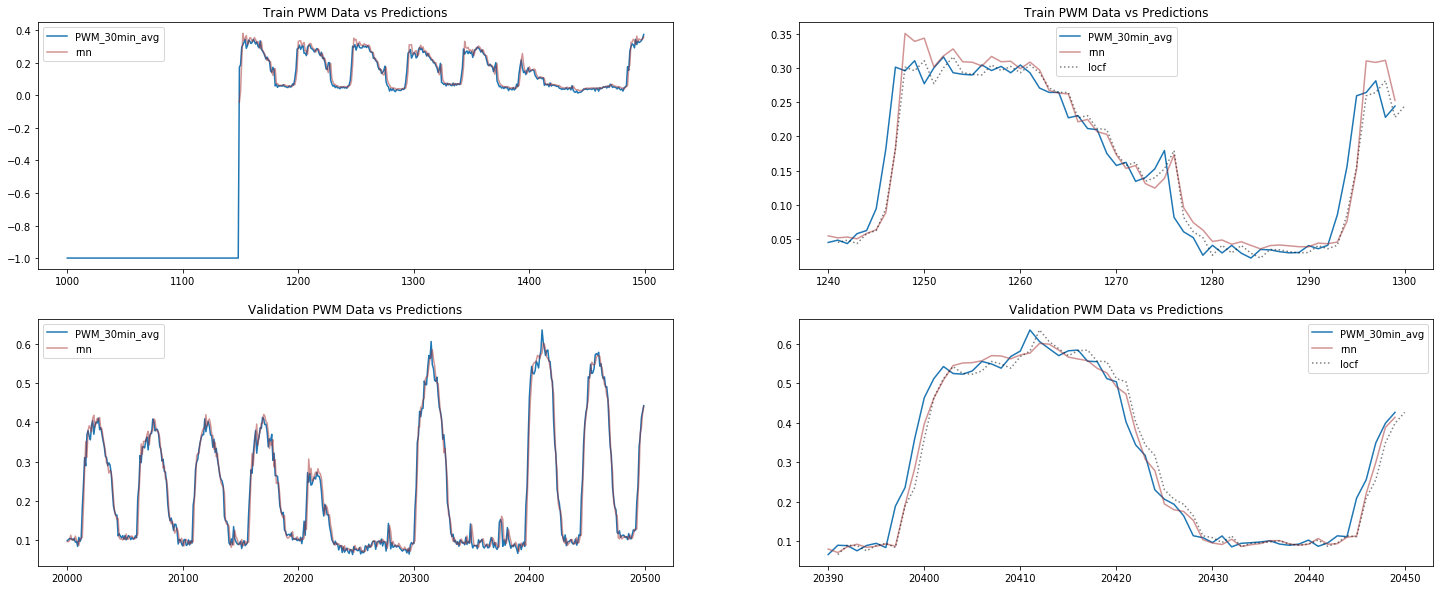

In [65]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [66]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-5.h5')

In [67]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-5-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-6), L2 (1e-6) Weight Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-6, 1e-6), recurrent_regularizer=l1_l2(1e-6, 1e-6), bias_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-6, 1e-6), recurrent_regularizer=l1_l2(1e-6, 1e-6), bias_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-6, 1e-6), recurrent_regularizer=l1_l2(1e-6, 1e-6), bias_regularizer=l1_l2(1e-6, 1e-6),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-6, 1e-6), recurrent_regularizer=l1_l2(1e-6, 1e-6), bias_regularizer=l1_l2(1e-6, 1e-6)))

# model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
# model.add(layers.CuDNNGRU(128, return_sequences=True))
# model.add(layers.CuDNNGRU(128, return_sequences=True))
# model.add(layers.CuDNNGRU(128))

model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [32]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [33]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0102-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [79]:
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-01-23 17:04:23.266355
Epoch 1/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6008 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.8576


Epoch 2/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6392 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.9638


Epoch 3/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5766 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 9.6753


Epoch 4/50


 - 13s - loss: 0.0169 - mean_absolute_percentage_error: 10.6846 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.5874


Epoch 5/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6959 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 9.0158


Epoch 6/50


 - 13s - loss: 0.0169 - mean_absolute_percentage_error: 10.5951 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 9.0020


Epoch 7/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6076 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.7435


Epoch 8/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.5673 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.1502


Epoch 9/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6393 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.9527


Epoch 10/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.5630 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.5876


Epoch 11/50


 - 13s - loss: 0.0168 - mean_absolute_percentage_error: 10.6662 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.0798


Epoch 12/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.6577 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.8813


Epoch 13/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.6088 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.4939


Epoch 14/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5910 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 9.5580


Epoch 15/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5737 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.9487


Epoch 16/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.4859 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 8.8589


Epoch 17/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.6298 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.4596


Epoch 18/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5280 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.4951


Epoch 19/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5190 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.8441


Epoch 20/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.4145 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.5447


Epoch 21/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5669 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 8.6302


Epoch 22/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.5908 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.6837


Epoch 23/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.3843 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.5814


Epoch 24/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.4601 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.4021


Epoch 25/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.5156 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 8.4962


Epoch 26/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5157 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 8.9555


Epoch 27/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.4480 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 9.1750


Epoch 28/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.5632 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.6180


Epoch 29/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.3398 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.6627


Epoch 30/50


 - 13s - loss: 0.0167 - mean_absolute_percentage_error: 10.4316 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 8.8923


Epoch 31/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.4053 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.3831


Epoch 32/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.3802 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.7283


Epoch 33/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.4569 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.1033


Epoch 34/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.5223 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 9.0506


Epoch 35/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.3822 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.5775


Epoch 36/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.3466 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.6113


Epoch 37/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.3973 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.7109


Epoch 38/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.3362 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 8.9094


Epoch 39/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.4242 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 9.3715


Epoch 40/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.3664 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 9.3472


Epoch 41/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.4259 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.6707


Epoch 42/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.5586 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.2692


Epoch 43/50


 - 13s - loss: 0.0166 - mean_absolute_percentage_error: 10.5250 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 9.2652


Epoch 44/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.3582 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.3016


Epoch 45/50


 - 14s - loss: 0.0165 - mean_absolute_percentage_error: 10.3969 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.0612


Epoch 46/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.4398 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 9.2755


Epoch 47/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.2568 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 8.7122


Epoch 48/50


 - 13s - loss: 0.0165 - mean_absolute_percentage_error: 10.3155 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 9.7210


Epoch 49/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.3669 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 12.4059


Epoch 50/50


 - 13s - loss: 0.0164 - mean_absolute_percentage_error: 10.3620 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 8.8614



Training Duration = 0:10:37.766471


In [80]:
# histories = []  # for first training session
histories.append(history.history)

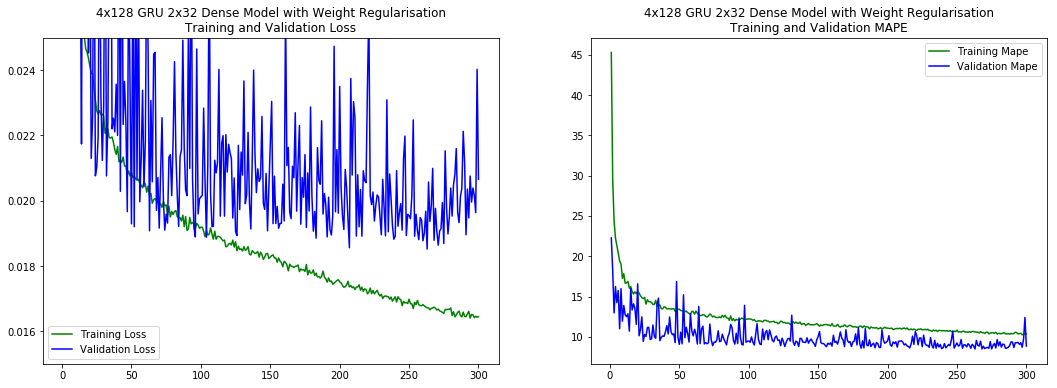

In [95]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim((0.015, 0.025))
plt.title('4x128 GRU 2x32 Dense Model with Weight Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Weight Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [82]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.744771
Validation MAE = 1.970003


In [86]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [87]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

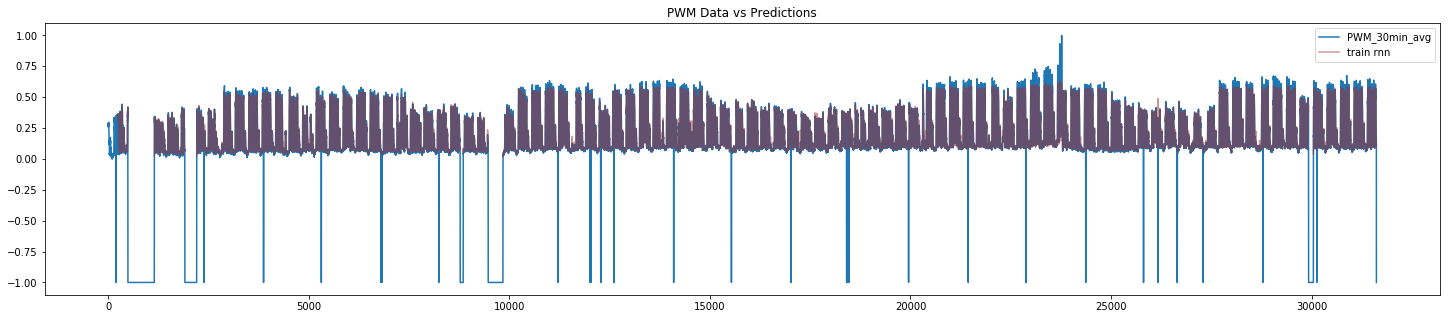

In [88]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

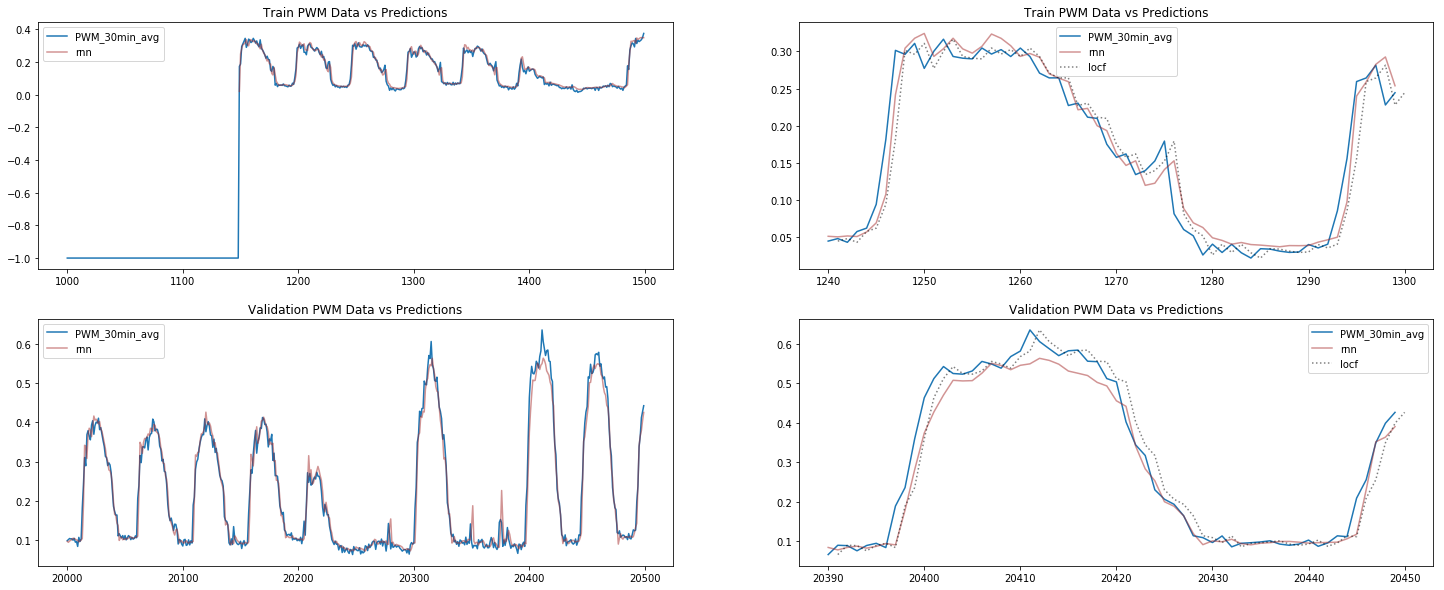

In [89]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [90]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-6-epch300.h5')

In [91]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-6-epch300-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with L1 (1e-7), L2 (1e-7) Weight Regularisation

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7),
                          return_sequences=True))
model.add(layers.CuDNNGRU(128, kernel_regularizer=l1_l2(1e-7, 1e-7), recurrent_regularizer=l1_l2(1e-7, 1e-7), bias_regularizer=l1_l2(1e-7, 1e-7)))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(lr=0.001, decay=0.001/50), loss='mae', metrics=['mape'])
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [22]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-epch50-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-epch50.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [73]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-01-28 16:27:14.178275
Epoch 1/50


 - 12s - loss: 0.0120 - mean_absolute_percentage_error: 7.9386 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 9.0385


Epoch 2/50


 - 12s - loss: 0.0121 - mean_absolute_percentage_error: 7.9054 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 8.0113


Epoch 3/50


 - 12s - loss: 0.0118 - mean_absolute_percentage_error: 7.7145 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 8.6962


Epoch 4/50


 - 12s - loss: 0.0120 - mean_absolute_percentage_error: 7.9111 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.1174


Epoch 5/50


 - 12s - loss: 0.0120 - mean_absolute_percentage_error: 7.7839 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.3448


Epoch 6/50


 - 12s - loss: 0.0120 - mean_absolute_percentage_error: 7.7905 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 8.3244


Epoch 7/50


 - 12s - loss: 0.0119 - mean_absolute_percentage_error: 7.8476 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 8.4443


Epoch 8/50


 - 12s - loss: 0.0119 - mean_absolute_percentage_error: 7.8286 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.5746


Epoch 9/50


 - 12s - loss: 0.0119 - mean_absolute_percentage_error: 7.7116 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 8.2419


Epoch 10/50


 - 12s - loss: 0.0119 - mean_absolute_percentage_error: 7.8444 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.2738


Epoch 11/50


 - 12s - loss: 0.0117 - mean_absolute_percentage_error: 7.6361 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.3570


Epoch 12/50


 - 12s - loss: 0.0118 - mean_absolute_percentage_error: 7.6945 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 9.3674


Epoch 13/50


 - 12s - loss: 0.0118 - mean_absolute_percentage_error: 7.7667 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 8.3588


Epoch 14/50


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 7.5699 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.9855


Epoch 15/50


 - 12s - loss: 0.0117 - mean_absolute_percentage_error: 7.7065 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.3147


Epoch 16/50


 - 12s - loss: 0.0117 - mean_absolute_percentage_error: 7.7491 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.6121


Epoch 17/50


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 7.5617 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.8898


Epoch 18/50


 - 12s - loss: 0.0117 - mean_absolute_percentage_error: 7.6002 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.7188


Epoch 19/50


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 7.6745 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 8.5545


Epoch 20/50


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 7.6529 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.5110


Epoch 21/50


 - 12s - loss: 0.0115 - mean_absolute_percentage_error: 7.5767 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 8.8800


Epoch 22/50


 - 12s - loss: 0.0115 - mean_absolute_percentage_error: 7.5951 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.5444


Epoch 23/50


 - 12s - loss: 0.0116 - mean_absolute_percentage_error: 7.6036 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.2895


Epoch 24/50


 - 12s - loss: 0.0114 - mean_absolute_percentage_error: 7.3993 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.6548


Epoch 25/50


 - 13s - loss: 0.0114 - mean_absolute_percentage_error: 7.5172 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.5086


Epoch 26/50


 - 13s - loss: 0.0115 - mean_absolute_percentage_error: 7.5620 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.4339


Epoch 27/50


 - 12s - loss: 0.0114 - mean_absolute_percentage_error: 7.4939 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 8.4873


Epoch 28/50


 - 12s - loss: 0.0114 - mean_absolute_percentage_error: 7.4544 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 8.3026


Epoch 29/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.3713 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 8.9157


Epoch 30/50


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 7.4780 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 8.3598


Epoch 31/50


 - 12s - loss: 0.0113 - mean_absolute_percentage_error: 7.3937 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.3203


Epoch 32/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.4438 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.4756


Epoch 33/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.4142 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.6677


Epoch 34/50


 - 12s - loss: 0.0111 - mean_absolute_percentage_error: 7.4605 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 9.1280


Epoch 35/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.3376 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.6571


Epoch 36/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.3858 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 8.7258


Epoch 37/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.3129 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 8.7385


Epoch 38/50


 - 12s - loss: 0.0111 - mean_absolute_percentage_error: 7.2431 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.5550


Epoch 39/50


 - 12s - loss: 0.0110 - mean_absolute_percentage_error: 7.2549 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.7299


Epoch 40/50


 - 12s - loss: 0.0112 - mean_absolute_percentage_error: 7.3283 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 8.3540


Epoch 41/50


 - 13s - loss: 0.0110 - mean_absolute_percentage_error: 7.2245 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.2795


Epoch 42/50


 - 12s - loss: 0.0110 - mean_absolute_percentage_error: 7.1714 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 8.5122


Epoch 43/50


 - 12s - loss: 0.0110 - mean_absolute_percentage_error: 7.1001 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 8.7934


Epoch 44/50


 - 12s - loss: 0.0109 - mean_absolute_percentage_error: 7.2395 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 8.7735


Epoch 45/50


 - 12s - loss: 0.0109 - mean_absolute_percentage_error: 7.2792 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 8.9054


Epoch 46/50


 - 12s - loss: 0.0109 - mean_absolute_percentage_error: 7.0932 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 8.7025


Epoch 47/50


 - 12s - loss: 0.0109 - mean_absolute_percentage_error: 7.1819 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 9.0299


Epoch 48/50


 - 12s - loss: 0.0108 - mean_absolute_percentage_error: 7.1324 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 8.5166


Epoch 49/50


 - 12s - loss: 0.0108 - mean_absolute_percentage_error: 7.2545 - val_loss: 0.0205 - val_mean_absolute_percentage_error: 8.7554


Epoch 50/50


 - 12s - loss: 0.0108 - mean_absolute_percentage_error: 7.1199 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 8.4765



Training Duration = 0:10:14.092791


In [74]:
# histories = []  ## if first training session
histories.append(history.history)

In [4]:
with open(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-epch300-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)

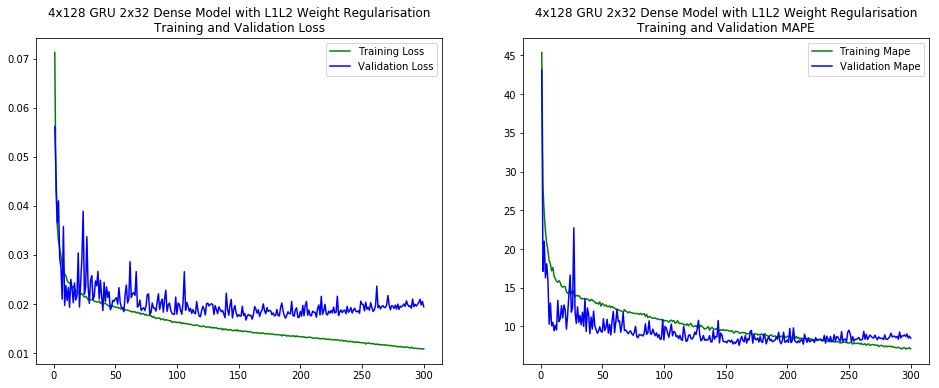

In [5]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with L1L2 Weight Regularisation\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with L1L2 Weight Regularisation\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [6]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.010813
Validation min loss = 0.016708
Validation min epoch = 155


In [76]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.150280
Validation MAE = 1.777419


In [77]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29754, 1)

In [78]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

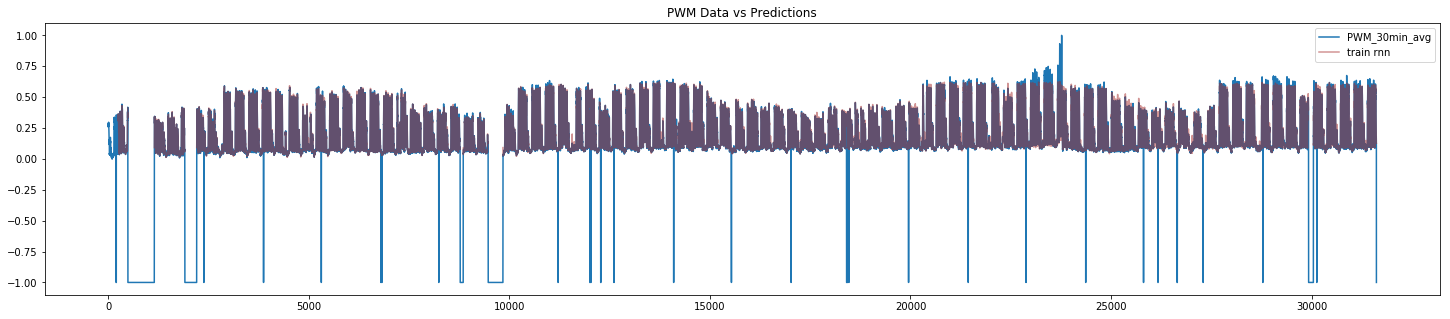

In [79]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

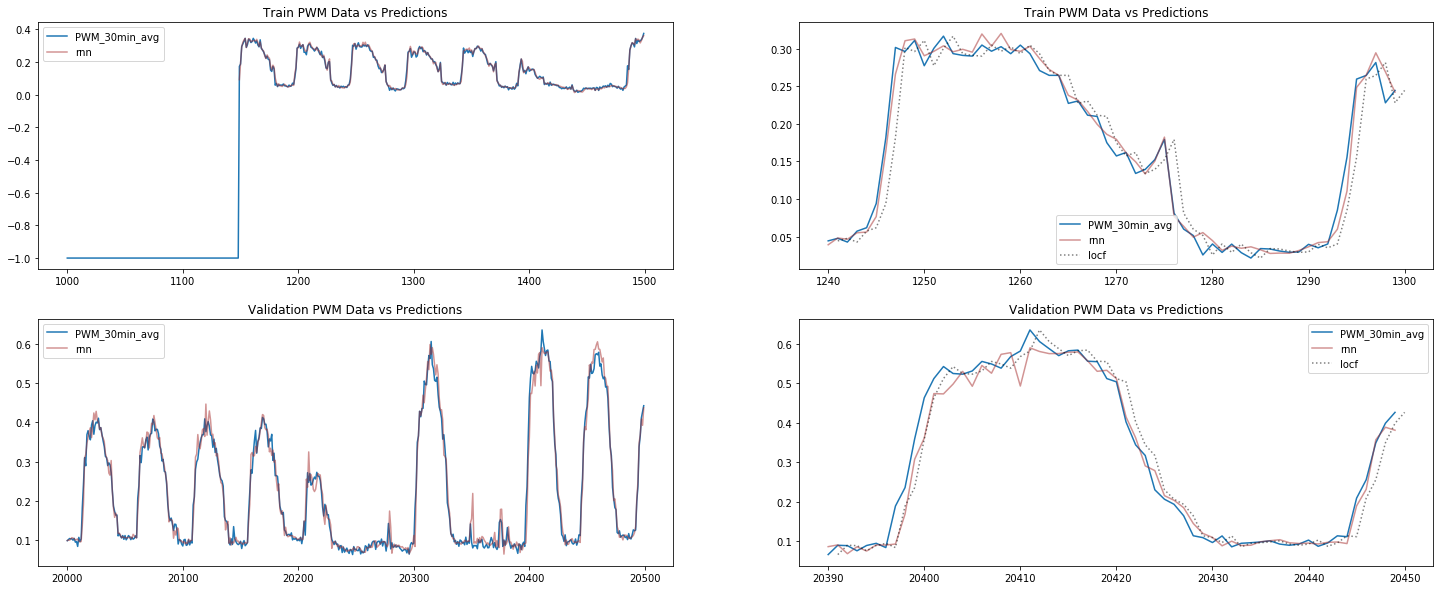

In [80]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [81]:
model.save('base-4x128gru-2x32dense-wgtl1l2-1e-7.h5')

In [82]:
with open('base-4x128gru-2x32dense-wgtl1l2-1e-7-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)